# 1조 홍성진 Exploration 03

## 모듈 import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 이미지 불러오기

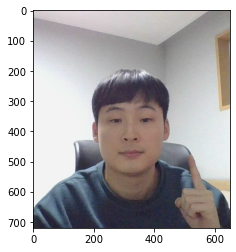

In [2]:
my_image_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\SJ.png"
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 불러옵니다.
img_crop_bgr = img_bgr[:, 350:1000] # 이미지를 원하는 만큼만 잘라보았다.
img_show = img_crop_bgr.copy() #출력용 이미지를 따로 보관합니다.
img_crop_rgb = cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB)  # B-G-R 에서 R-G-B로 색 변환
plt.imshow(img_crop_rgb)
plt.show()

## detector를 선언

In [3]:
detector_hog = dlib.get_frontal_face_detector()

## detector_hog 를 이용하여 bounding box를 추출

In [4]:
dlib_rects = detector_hog(img_crop_rgb, 1)  # (image, num of image pyramid)

## 찾은 얼굴을 화면에 출력

rectangles[[(216, 291) (439, 514)]]


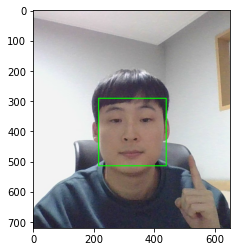

In [5]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있음.
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    r = dlib_rect.right()
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## weight file 다운 완료/bz2 압축 해제 완료

## landmark 모델 불러오기

In [6]:
model_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\models\shape_predictor_68_face_landmarks.dat"
landmark_predictor = dlib.shape_predictor(model_path)

## `RGB이미지`와 `dlib.rectangle`을 입력받아, `dlib.full_object_detection` 으로 반환하기

In [7]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_crop_rgb,dlib_rect)
    # face landmark 좌표를 저장해둡니다.
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


## landmark 출력하기

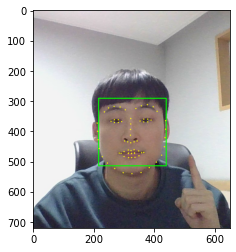

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # 위에서 했지만, img_show로 다시 landmark 했기때문에 다시 img_show_rgb했다.
plt.imshow(img_show_rgb)
plt.show()

## 좌표 확인

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[27])   # 코의 index 값은 30, 콧등 쪽을 기준으로 두고 싶어서 27 정도로 바꿈
    x = landmark[27][0]
    y = landmark[27][1] - dlib_rect.height()//2
    w = h = int(dlib_rect.width()*1.7) # 스티커사진 좀 크게 하고싶어서 1.7배 함.
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(322, 358)
(x,y) : (322, 246)
(w,h) : (380, 380)


## 스티커 이미지를 읽어서 적용

In [10]:
sticker_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\cat.png"
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다.
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(380, 380, 3)


## 원본 이미지에서 이미지 스티커를 추가하기 위한 좌표 조정

In [11]:
refined_x = x - w//2
refined_y = y
print('(rx,ry) : (%d,%d)'%(refined_x, refined_y))

(rx,ry) : (132,246)


## 음수값 예외처리

In [12]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (132,246)


## 원본이미지에 스티커 적용하기

In [13]:
# 복잡해 보이지만 img_show[from:to] 형식
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

## 결과 이미지 출력

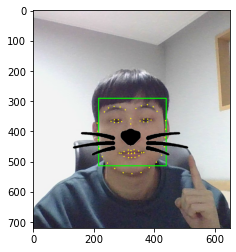

In [14]:

img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
# dst = cv2.addWeighted(img_show_rgb, 0.7, img_sticker, 0.3, 0)
# cv2.imshow('cv2.addWeighted', dst)
plt.imshow(img_show_rgb)
plt.show()

## bounding box와 landmark 제거하기

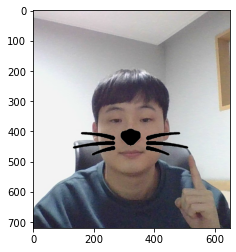

In [15]:
sticker_area = img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 다양한 얼굴 각도로 시도해보기

### 1. 왼쪽 방향

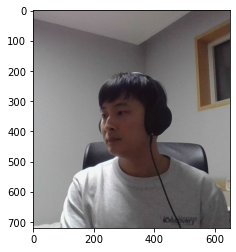

In [16]:
my_image_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\left_face.png"
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 불러옵니다.
img_crop_bgr = img_bgr[:, 350:1000] # 이미지를 원하는 만큼만 잘라보았다.
img_show = img_crop_bgr.copy() #출력용 이미지를 따로 보관합니다.
img_crop_rgb = cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB)  # B-G-R 에서 R-G-B로 색 변환
plt.imshow(img_crop_rgb)
plt.show()

### 왼쪽 Detrction

In [17]:
dlib_rects = detector_hog(img_crop_rgb, 1)

rectangles[[(180, 284) (366, 469)]]


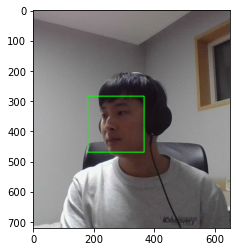

In [18]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    r = dlib_rect.right()
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 왼쪽 Landmark

In [19]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_crop_rgb,dlib_rect)
    # face landmark 좌표를 저장해둡니다.
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


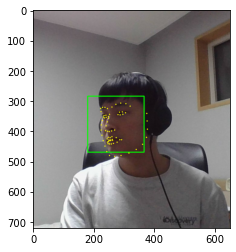

In [20]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # 위에서 했지만, img_show로 다시 landmark 했기때문에 다시 img_show_rgb했다.
plt.imshow(img_show_rgb)
plt.show()

### 좌표

In [21]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])   # 이번의 코끝쪽인 33으로 지정
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = int(dlib_rect.width()*1) # 스티커사진 좀 크게 하고싶어서 1.7배 함.
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(251, 401)
(x,y) : (241, 289)
(w,h) : (187, 187)


### 스티커

In [22]:
sticker_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\cat.png"
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다.
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(187, 187, 3)


In [23]:
refined_x = x - w//2
refined_y = y
print('(rx,ry) : (%d,%d)'%(refined_x, refined_y))

(rx,ry) : (148,289)


In [24]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (148,289)


### 이미지 적용

In [25]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

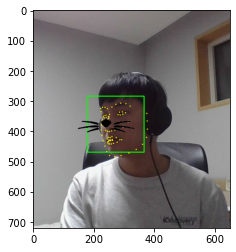

In [26]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 최종 결과

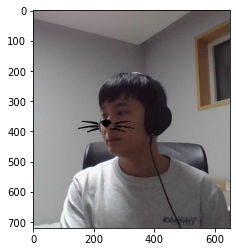

In [27]:
sticker_area = img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 크게 얼굴 각도 변경

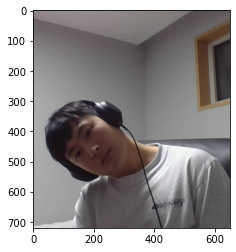

In [28]:
my_image_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\change_degree.png"
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 불러옵니다.
img_crop_bgr = img_bgr[:, 350:1000] # 이미지를 원하는 만큼만 잘라보았다.
img_show = img_crop_bgr.copy() #출력용 이미지를 따로 보관합니다.
img_crop_rgb = cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB)  # B-G-R 에서 R-G-B로 색 변환
plt.imshow(img_crop_rgb)
plt.show()

### Detection

In [29]:
dlib_rects = detector_hog(img_crop_rgb, 1)

rectangles[]


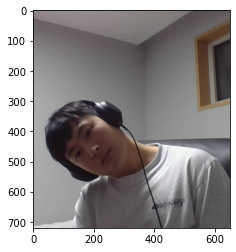

In [30]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    r = dlib_rect.right()
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴을 인식하지 못한다.

# 3. 살짝 얼굴 각도 변경

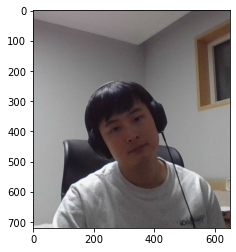

In [31]:
my_image_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\little.png"
img_bgr = cv2.imread(my_image_path)  # OpenCV로 이미지를 불러옵니다.
img_crop_bgr = img_bgr[:, 350:1000] # 이미지를 원하는 만큼만 잘라보았다.
img_show = img_crop_bgr.copy() #출력용 이미지를 따로 보관합니다.
img_crop_rgb = cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB)  # B-G-R 에서 R-G-B로 색 변환
plt.imshow(img_crop_rgb)
plt.show()

### Detection

In [32]:
dlib_rects = detector_hog(img_crop_rgb, 1)

rectangles[[(242, 325) (428, 511)]]


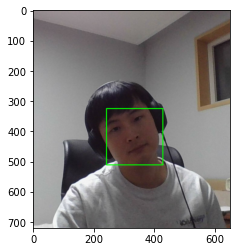

In [33]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    r = dlib_rect.right()
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### Landmark

In [34]:
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_crop_rgb,dlib_rect)
    # face landmark 좌표를 저장해둡니다.
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


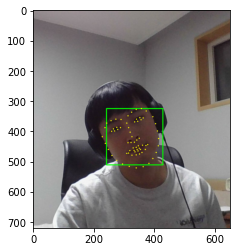

In [35]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # 위에서 했지만, img_show로 다시 landmark 했기때문에 다시 img_show_rgb했다.
plt.imshow(img_show_rgb)
plt.show()

### 좌표

In [36]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])   # 이번의 코끝쪽인 33으로 지정
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = int(dlib_rect.width()*1) # 스티커사진 좀 크게 하고싶어서 1.7배 함.
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(334, 436)
(x,y) : (326, 325)
(w,h) : (187, 187)


### 스티커

In [37]:
sticker_path = os.getenv("USERPROFILE") + "\Self_Study\LMS\Exp\Ex_3\camera_sticker\images\cat.png"
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다.
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(187, 187, 3)


In [38]:
refined_x = x - w//2
refined_y = y
print('(rx,ry) : (%d,%d)'%(refined_x, refined_y))

(rx,ry) : (233,325)


In [39]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (233,325)


### 이미지 적용

In [40]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

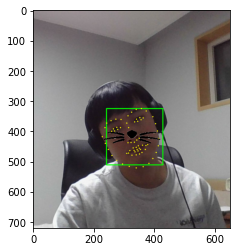

In [41]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 최종 결과

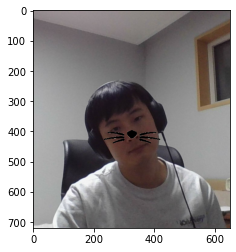

In [42]:
sticker_area = img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_crop_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_crop_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

이번 프로젝트를 하며 어려웠던 점은, 먼저 좌표값을 계산하는 것이었다.
Detection이 된 사각 범위 내의 좌표와, Landmark가 된 점선들의 좌표를 기준으로, 내가 원하는 좌표에 스티커를 붙이는것이 생각보다 쉽지않았다. 좌표값에서 숫자를 높히면, 올라갈거라고 일반적인 수학 x-y그래프를 '상상'을 하여 움직여 보았는데, 생각처럼 움직이지 않아서 종이를 꺼내들며까지 좌표를 계산하는 나의 모습이 한편으로는 우수웠다.

  사실 대부분의 코드들은 이미 짜여진 곳에서 움직이므로, 큰 어려움을 겪지는 않았는데, 몇 가지가 나를 크게 괴롭혔다.
먼저, 이미 만들어진 패키지를 가져다 쓰는거지만, Detection의 원리와 Landmark를 해주는 이론이 궁금했었다. 왜냐하면 만들어진 코드를 가져다 쓰니까, 내 얼굴을 학습해서 포인트를 가져다 오는건지 포인트가 마음에 안들면 바꿀 수 없는지 등 뭔가 내가 만든다는 느낌이 들지 않아서 였기 때문이다. 하지만 지금 당장 이 정보들을 습득하기에는 너무 깊은 이론에 빠져야 한다는 사실을 알아채고 우선 빠져나왔다.
  다음으로는 스티커의 방향이었다. 얼굴을 좌 우로 움직여도, 심하게 꺾지만 않는거면, 멋진 패키지가 알아서 나의 얼굴을 잡아내는 것 까지는 좋았다. 다만, 내 얼굴이 움직였다고 해서 스티커까지 알아서 따라오지는 않는다. 그래서 이 방향을 잡아내는 방법을 여러 방면으로 알아보았지만.. 결국 알아내지 못하였다. 그게 바로 위에 보이는 마지막 사진이다.
  마지막으로는 opencv의 `cv2.addWeighted()` 였다. 이 함수는, 노드에서 참고하라고 언급했기에, 한번 해 보고싶었는데, 어떤 자료를 찾아봐도 나에게는 오류만 날 뿐이었다.. 꽤 오랜시간 알아보다가 결국 헤 내지 못한 채 이렇게 이실직고 한다..
  
  이번 프로젝트를 하며 알아낸 점은,
  - 얼굴의 각도가 심하게 바뀌면 얼굴을 인식하지 못한다는 점
  - detection 이나 Landmark 해주는 패키지의 기술이 매우 훌륭하다는 점.
  
  하지만 이번 프로젝트에서 모호한 점은
  - detrction, Landmark에 대한 깊은 이론 (정확히 어떤 코드로 저렇게 작동하는지)
  - 얼굴의 각도에 따라서 스티커도 움직이게 할 수있는 방법을 찾지 못하였다.
  
  루브릭 평가 지표를 맞추기 위해 시도한 것들로는
  - 원본 사진에 스티커 사진이 알맞은 위치에 올라갈 수 있도록 좌표를 미세하게 조정하였고
  - 스티커의 크기도 적절한 사이즈로 조절 해 보았다.
  - 또한, 얼굴의 각도를 작게 돌려도보았고, 일부러 큰 각도로 돌려도 보았다.
  - 초기 이미지 사진보다 어둡게도 촬영 해 보았고,
  - 위의 코드에는 나와있지 않지만, 촬영거리도, 얼굴이 인식 될 정도의 거리면 인식이 된다는 점도 확인하였다.
  
  만약 루브릭 평가 관련 지표를 달성하지 못하였다면.. opencv의 `cv2.addWeighted()` 함수를 결국 알아내지 못해 적용하지 못하였던 점이 가장 큰 원인이 될 것같고, 또한 얼굴 방향에 따른 스티커 각도 변화역시 찾아내지 못했다는 점에서 관련 지표를 달성하지 못하지 않았을까 추정해 본다.
  
  다음에 관련된 노드를 진행하게 된다면, 그 때는 좀 더 자세하게 이론적인 부분에 대하여 파헤치고 싶다.
  
  감사합니다.